100%|██████████| 8921/8921 [14:54<00:00,  9.98it/s]


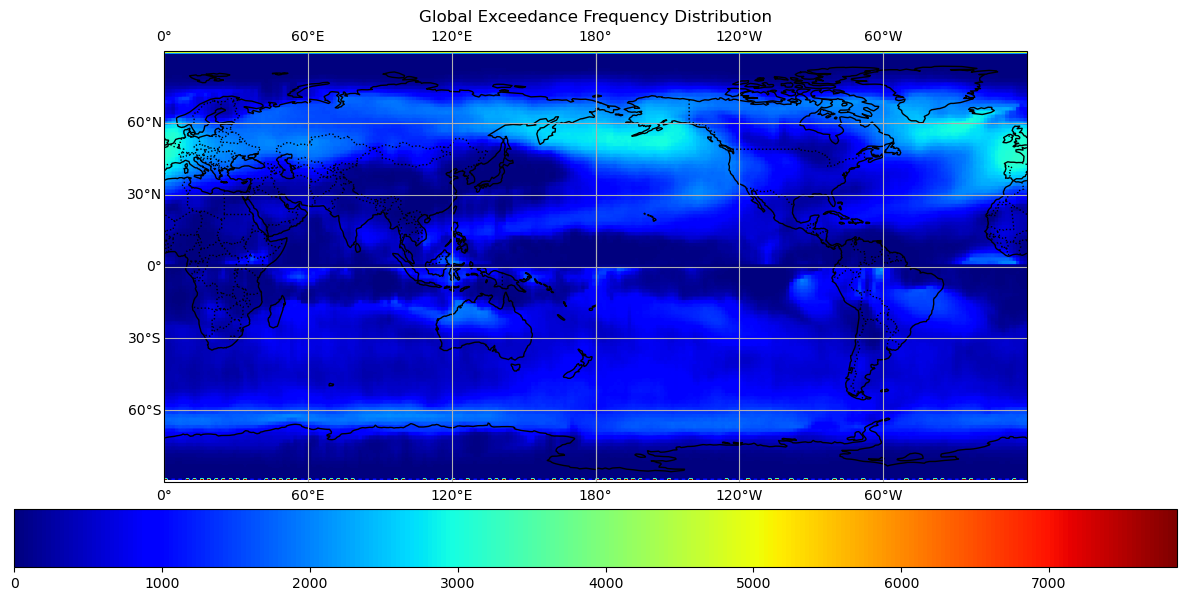

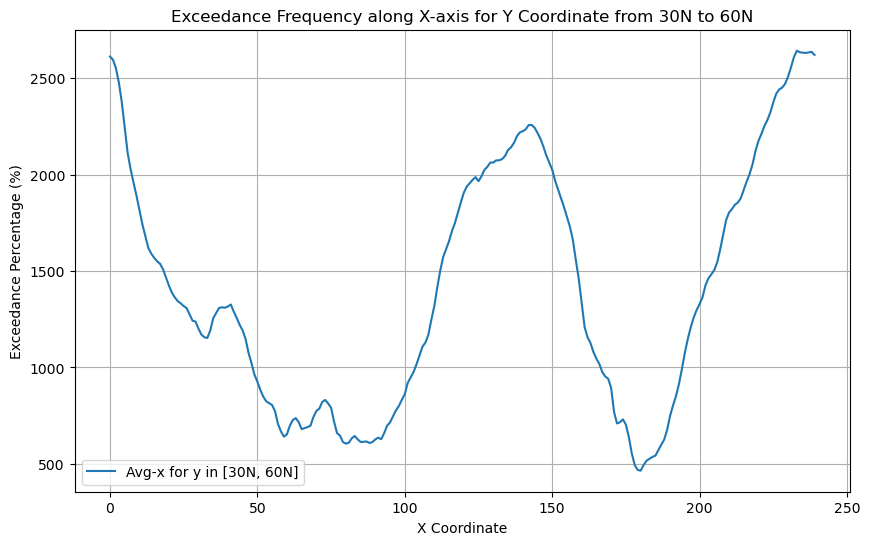

(240,)
Data saved to /scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/zonal_freq_filtered_ver0416.npy


In [1]:
# higher threshold: 100m2s-2
### FIG3
#working: 0211


import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import os
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime
import pandas as pd
from tqdm import tqdm

results_df = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')

# Load Flux Capacity Data
flux_capacity_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/Flux_Capacity_DJF.npy"
flux_capacity_data = np.load(flux_capacity_path)


# Function to load flux data for a given time
def load_flux_data(year, month, day, hour):
    """
    Load flux data (F1, F2, F3) for a given date and time, and return their sum.
    The file name is expected to be in the format F1_YYYY_YYYY_MM_DD_HH.npy.
    """
    base_path = "/scratch/negishi/yan481/KenYan_Traffic_Model/hn2016-falwa_calculation"
    f1_file = os.path.join(base_path, f"F1_{year}_{year}_{month}_{day}_{hour}.npy")
    f2_file = os.path.join(base_path, f"F2_{year}_{year}_{month}_{day}_{hour}.npy")
    f3_file = os.path.join(base_path, f"F3_{year}_{year}_{month}_{day}_{hour}.npy")

    f1 = np.load(f1_file)
    f2 = np.load(f2_file)
    f3 = np.load(f3_file)
    
    return f1 + f2 + f3

# Function to calculate grid index
def calculate_grid_index(lat, lon):
    """
    Calculate the grid index in the 121x240 flux array for a given latitude and longitude.
    Latitude range is 90 to -90 (121 steps), and longitude range is 0 to 360 (240 steps).
    """
    lat_idx = int((90 + lat) / 1.5)  # Converting latitude to index
    lon_idx = int(lon / 1.5)         # Converting longitude to index
    return lat_idx, lon_idx




# Initialize global exceedance frequency heatmap
global_exceedance_freq = np.zeros((121, 240))  # grid size 121x240

def process_event(time_str):
    global global_exceedance_freq  # Declare the variable as global

    try:
        dt = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")
    except ValueError:
        dt = datetime.strptime(time_str, "%Y_%m_%d_%H")

    year = dt.strftime('%Y')
    month = dt.strftime('%m')
    day = dt.strftime('%d')
    hour = dt.strftime('%H')

    total_flux = load_flux_data(year, month, day, hour)

    # Calculate flux difference
    flux_difference = total_flux - flux_capacity_data

    # Update the global heatmap
    global_exceedance_freq += (flux_difference > 100).astype(int)

    
# Process all events
for row in tqdm(results_df.itertuples(index=False), total=len(results_df)):
    process_event(row.Time)

# Calculate the total number of events
total_events = len(results_df)

# Convert frequency to percentage
global_exceedance_freq_percentage = (global_exceedance_freq / total_events)



# Set up the map using Cartopy
fig = plt.figure(figsize=(15, 7))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(draw_labels=True, dms=False, x_inline=False, y_inline=False)

# Plot the global exceedance frequency heatmap
heatmap = ax.imshow(global_exceedance_freq, transform=ccrs.PlateCarree(), cmap='jet', origin='lower', extent=[0, 360, -90, 90])

plt.colorbar(heatmap, ax=ax, orientation='horizontal', pad=0.05)
plt.title('Global Exceedance Frequency Distribution')
plt.show()


y_range_data = global_exceedance_freq[80:101, :]

# Calculate the average along the y-axis (axis=0)
zonal_freq = np.nanmean(y_range_data, axis=0)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(zonal_freq, label='Avg-x for y in [30N, 60N]')
plt.xlabel('X Coordinate')
plt.ylabel('Exceedance Percentage (%)')
plt.title('Exceedance Frequency along X-axis for Y Coordinate from 30N to 60N')
plt.legend()
plt.grid(True)
plt.show()

print(zonal_freq.shape)

output_directory = "/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/"
file_path = os.path.join(output_directory, 'zonal_freq_filtered_ver0416.npy')


# Save only the data part of the masked array
np.save(file_path, zonal_freq)
print(f"Data saved to {file_path}")



/tmp/ipykernel_2432076/2693043091.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'Longitude_bin'] = (filtered_data['Longitude'] // bin_size * bin_size).astype(int)


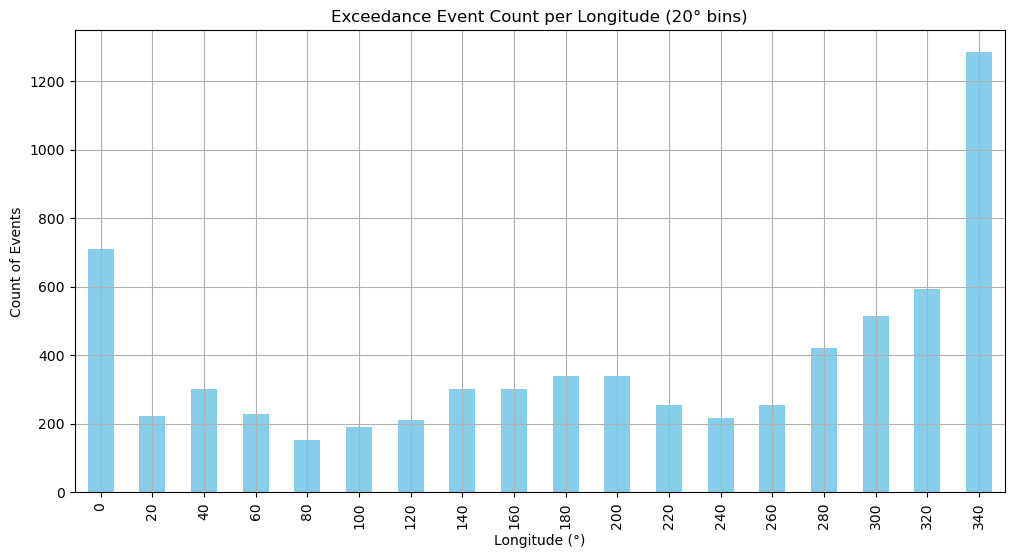

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_event_counts(data, latitude_range, longitude_range, bin_size):
    """
    Plots the event counts grouped by longitude bins.

    Parameters:
    - data: DataFrame with the event data.
    - latitude_range: tuple (min, max) for filtering latitude.
    - longitude_range: tuple (min, max) for filtering longitude.
    - bin_size: size of each longitude bin in degrees.
    """
    # Filter data based on Latitude and Longitude
    filtered_data = data[
        (data['Latitude'] >= latitude_range[0]) & (data['Latitude'] <= latitude_range[1]) &
        (data['Longitude'] >= longitude_range[0]) & (data['Longitude'] <= longitude_range[1])
    ]

    # Group by longitude bins using .loc to avoid SettingWithCopyWarning
    filtered_data.loc[:, 'Longitude_bin'] = (filtered_data['Longitude'] // bin_size * bin_size).astype(int)
    event_counts = filtered_data.groupby('Longitude_bin').size()

    # Plotting the bar chart
    plt.figure(figsize=(12, 6))
    event_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Exceedance Event Count per Longitude ({bin_size}° bins)')
    plt.xlabel('Longitude (°)')
    plt.ylabel('Count of Events')
    plt.grid(True)
    plt.show()

data = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')
plot_event_counts(data, latitude_range=(30, 60), longitude_range=(0, 360), bin_size= 20)



/tmp/ipykernel_2432076/294561691.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data.loc[:, 'Longitude_bin'] = (filtered_data['Longitude'] // bin_size * bin_size).astype(int)


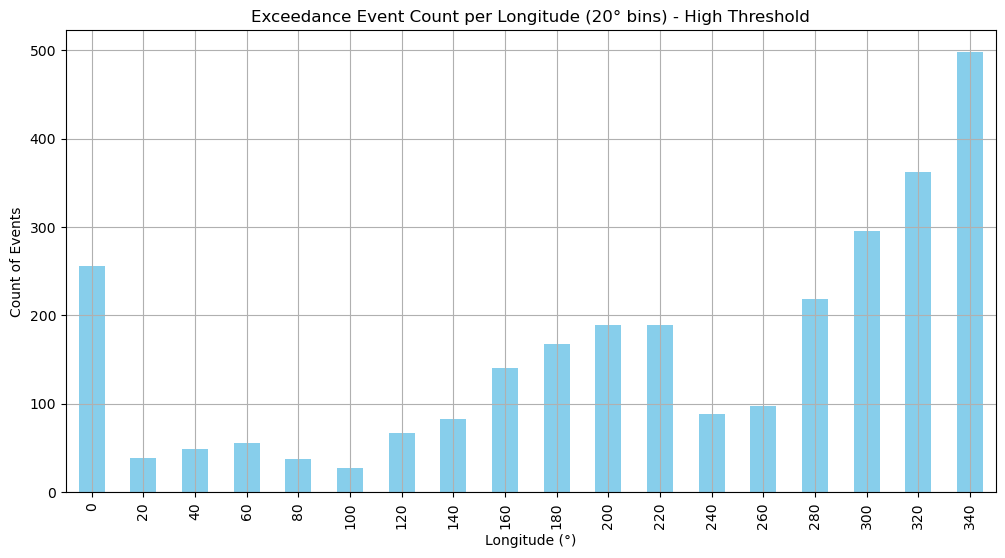

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_event_counts(data, latitude_range, longitude_range, bin_size):
    """
    Plots the event counts grouped by longitude bins.

    Parameters:
    - data: DataFrame with the event data.
    - latitude_range: tuple (min, max) for filtering latitude.
    - longitude_range: tuple (min, max) for filtering longitude.
    - bin_size: size of each longitude bin in degrees.
    """
    # Filter data based on Latitude and Longitude
    filtered_data = data[
        (data['Latitude'] >= latitude_range[0]) & (data['Latitude'] <= latitude_range[1]) &
        (data['Longitude'] >= longitude_range[0]) & (data['Longitude'] <= longitude_range[1])
    ]

    # Group by longitude bins using .loc to avoid SettingWithCopyWarning
    filtered_data.loc[:, 'Longitude_bin'] = (filtered_data['Longitude'] // bin_size * bin_size).astype(int)
    event_counts = filtered_data.groupby('Longitude_bin').size()

    # Plotting the bar chart
    plt.figure(figsize=(12, 6))
    event_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Exceedance Event Count per Longitude ({bin_size}° bins) - High Threshold')
    plt.xlabel('Longitude (°)')
    plt.ylabel('Count of Events')
    plt.grid(True)
    plt.show()

data = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221_high_threshold/filtered_results_with_hour_difference.csv')
plot_event_counts(data, latitude_range=(30, 60), longitude_range=(0, 360), bin_size= 20)



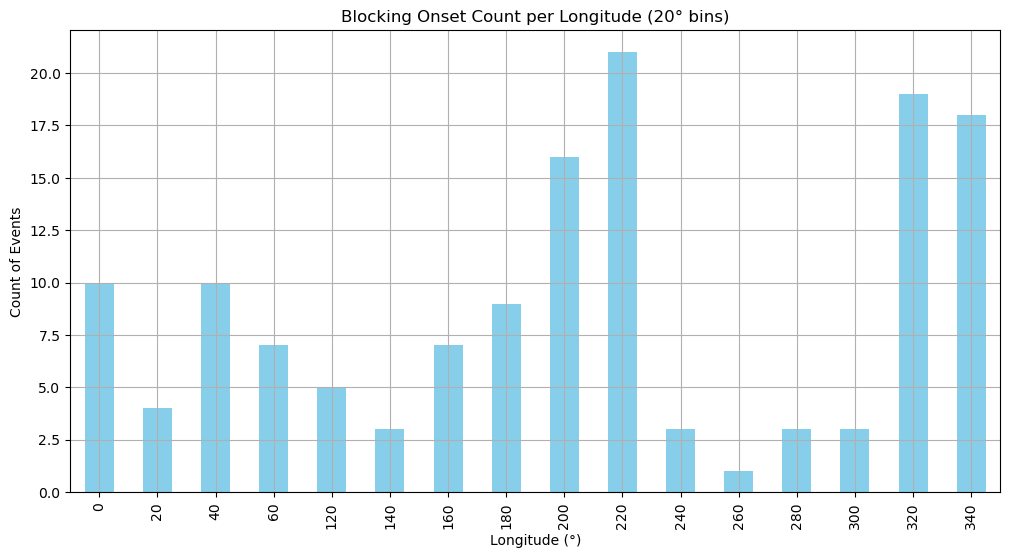

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Load blocking events data
data1 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0.npy', allow_pickle=True)
data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0SH.npy', allow_pickle=True)

def plot_blocking_events(bin_size):

    # Combine the data from both files
    combined_data = np.concatenate((data1, data2))

    # Create a DataFrame from the numpy array for easier manipulation
    columns = ['Date', 'Duration', 'Longitude', 'Latitude']
    df = pd.DataFrame(combined_data, columns=columns)

    # Extract numerical values for Longitude and Latitude
    df['Longitude'] = df['Longitude'].apply(lambda x: float(x.split(': ')[1]))
    df['Latitude'] = df['Latitude'].apply(lambda x: float(x.split(': ')[1]))

    # Convert 'Date' to datetime objects and extract relevant temporal and geographical information
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[(df['Latitude'] >= 30) & (df['Latitude'] <= 60) &
            (df['Longitude'] >= 0) & (df['Longitude'] <= 360) &
            (df['Date'].dt.month.isin([12, 1, 2])) &
            (df['Date'].dt.year >= 1979) & (df['Date'].dt.year <= 2016)]

    # Group by longitude (user-defined bin size)
    df['Longitude_bin'] = (df['Longitude'] // bin_size * bin_size).astype(int)
    event_counts = df.groupby('Longitude_bin').size()

    # Plotting the bar chart
    plt.figure(figsize=(12, 6))
    event_counts.plot(kind='bar', color='skyblue')
    plt.title(f'Blocking Onset Count per Longitude ({bin_size}° bins)')
    plt.xlabel('Longitude (°)')
    plt.ylabel('Count of Events')
    plt.grid(True)
    plt.show()


plot_blocking_events(20)


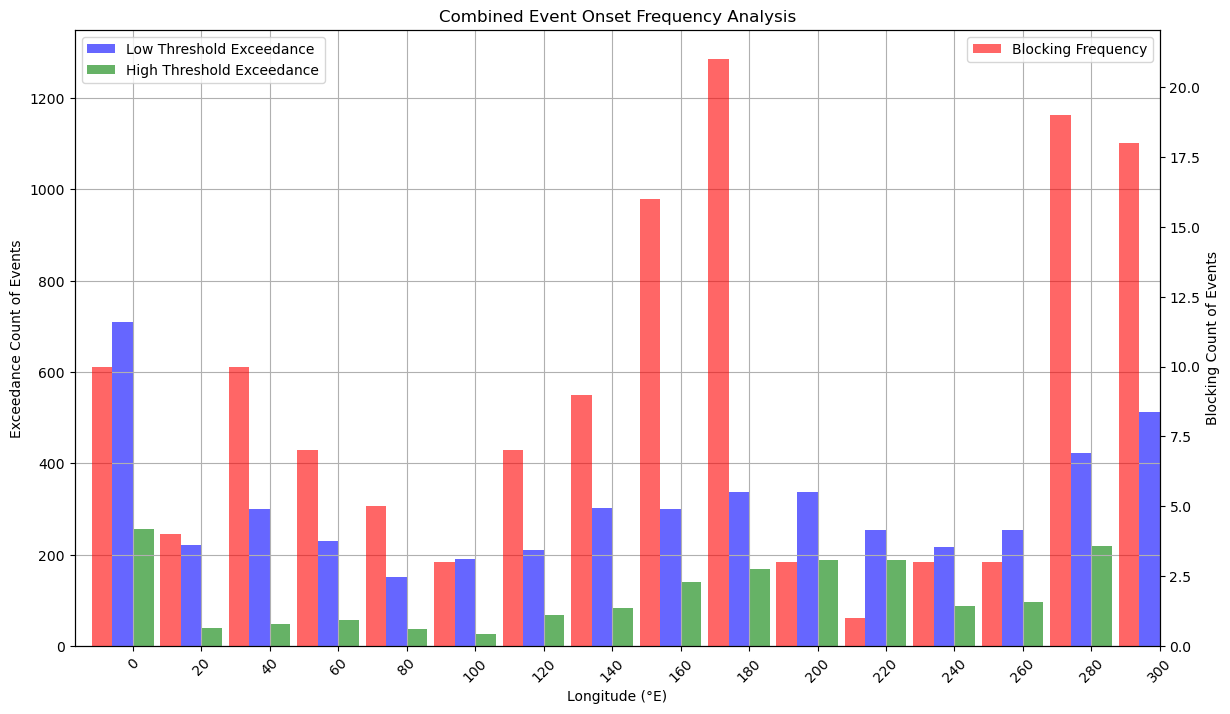

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# Load the exceedance event data
data_low = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')
data_high = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221_high_threshold/filtered_results_with_hour_difference.csv')

# Function to prepare data
def prepare_data(data, latitude_range, longitude_range, bin_size):
    # Filter data based on Latitude and Longitude
    filtered_data = data[
        (data['Latitude'] >= latitude_range[0]) & (data['Latitude'] <= latitude_range[1]) &
        (data['Longitude'] >= longitude_range[0]) & (data['Longitude'] <= longitude_range[1])
    ].copy()  # Explicitly create a copy of the filtered data

    # Group by longitude bins using .loc to avoid SettingWithCopyWarning
    filtered_data['Longitude_bin'] = (filtered_data['Longitude'] // bin_size * bin_size).astype(int)
    event_counts = filtered_data.groupby('Longitude_bin').size()
    return event_counts


# Prepare event counts
event_counts_low = prepare_data(data_low, (30, 60), (0, 360), 20)
event_counts_high = prepare_data(data_high, (30, 60), (0, 360), 20)

# Load blocking events data
data1 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0.npy', allow_pickle=True)
data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0SH.npy', allow_pickle=True)

# Function to plot blocking events
def plot_blocking_events(data1, data2, bin_size):
    combined_data = np.concatenate((data1, data2))
    columns = ['Date', 'Duration', 'Longitude', 'Latitude']
    df = pd.DataFrame(combined_data, columns=columns)
    df['Longitude'] = df['Longitude'].apply(lambda x: float(x.split(': ')[1]))
    df['Latitude'] = df['Latitude'].apply(lambda x: float(x.split(': ')[1]))
    df['Date'] = pd.to_datetime(df['Date'])
    df = df[(df['Latitude'] >= 30) & (df['Latitude'] <= 60) &
            (df['Longitude'] >= 0) & (df['Longitude'] <= 360) &
            (df['Date'].dt.month.isin([12, 1, 2])) &
            (df['Date'].dt.year >= 1979) & (df['Date'].dt.year <= 2016)]
    df['Longitude_bin'] = (df['Longitude'] // bin_size * bin_size).astype(int)
    event_counts = df.groupby('Longitude_bin').size()
    return event_counts

# Prepare blocking events
blocking_counts = plot_blocking_events(data1, data2, 20)

# Plotting all data
plt.figure(figsize=(14, 8))
ax = plt.subplot(1, 1, 1)
ax2 = ax.twinx()

# Exceedance frequencies
event_counts_low.plot(kind='bar', color='blue', alpha=0.6, label='Low Threshold Exceedance', ax=ax, position=1, width=0.3)
event_counts_high.plot(kind='bar', color='green', alpha=0.6, label='High Threshold Exceedance', ax=ax, position=0, width=0.3)

# Blocking frequencies
blocking_counts.plot(kind='bar', color='red', alpha=0.6, label='Blocking Frequency', ax=ax2, position=2, width=0.3)

ax.set_xlabel('Longitude (°E)')
ax.set_ylabel('Exceedance Count of Events')
ax2.set_ylabel('Blocking Count of Events')
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.grid(True)
# Set x-axis labels horizontal
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plt.title('Combined Event Onset Frequency Analysis')
plt.show()


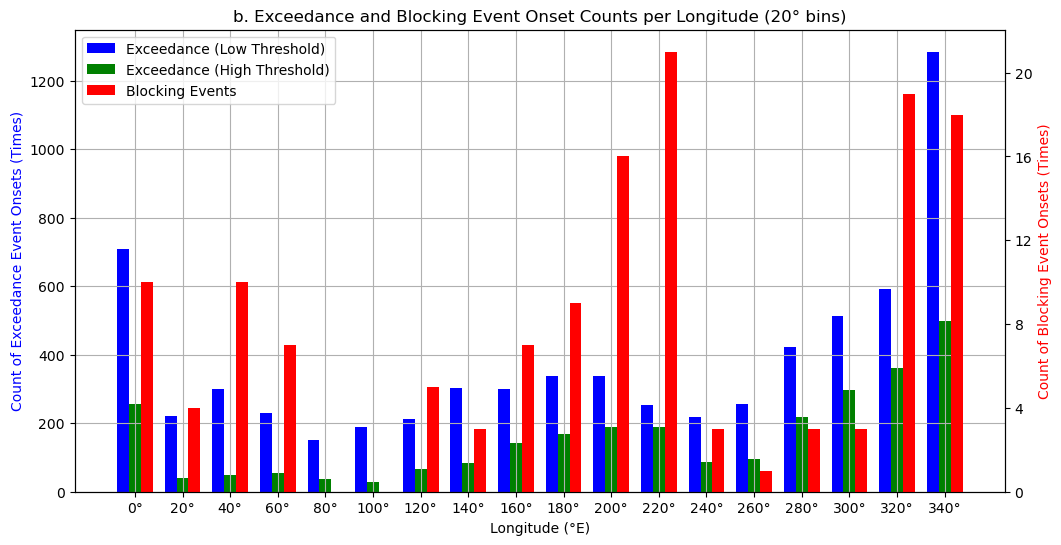

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from matplotlib.ticker import MaxNLocator

def plot_event_counts(data, latitude_range, longitude_range, bin_size, ax, width, position, color, label):
    # Add a longitude bin column before filtering
    data['Longitude_bin'] = (data['Longitude'] // bin_size * bin_size).astype(int)

    # Filter data based on Latitude and Longitude
    filtered_data = data[
        (data['Latitude'] >= latitude_range[0]) & (data['Latitude'] <= latitude_range[1]) &
        (data['Longitude'] >= longitude_range[0]) & (data['Longitude'] <= longitude_range[1])
    ]
    
    event_counts = filtered_data.groupby('Longitude_bin').size().reindex(range(0, 360, bin_size), fill_value=0)

    # Adjust positions for bar placement
    offsets = np.arange(len(event_counts)) + position

    # Plot the bar chart
    ax.bar(offsets, event_counts, width=width, color=color, label=label, align='center')

def plot_blocking_events(bin_size, ax, width, position, color, label):
    # Load blocking events data
    data1 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0.npy', allow_pickle=True)
    data2 = np.load('/scratch/negishi/yan481/KenYan_Traffic_Model/Ka Ying Blocking Data/BlockingEventDate4.0SH.npy', allow_pickle=True)

    # Combine the data from both files
    combined_data = np.concatenate((data1, data2))

    # Create a DataFrame from the numpy array for easier manipulation
    columns = ['Date', 'Duration', 'Longitude', 'Latitude']
    df = pd.DataFrame(combined_data, columns=columns)

    # Extract numerical values for Longitude and Latitude
    df['Longitude'] = df['Longitude'].apply(lambda x: float(x.split(': ')[1]))
    df['Latitude'] = df['Latitude'].apply(lambda x: float(x.split(': ')[1]))

    # Convert 'Date' to datetime objects and extract relevant temporal and geographical information
    df['Date'] = pd.to_datetime(df['Date'])
    df['Longitude_bin'] = (df['Longitude'] // bin_size * bin_size).astype(int)

    df = df[(df['Latitude'] >= 30) & (df['Latitude'] <= 60) &
            (df['Longitude'] >= 0) & (df['Longitude'] <= 360) &
            (df['Date'].dt.month.isin([12, 1, 2])) &
            (df['Date'].dt.year >= 1979) & (df['Date'].dt.year <= 2016)]

    event_counts = df.groupby('Longitude_bin').size().reindex(range(0, 360, bin_size), fill_value=0)

    # Adjust positions for bar placement
    offsets = np.arange(len(event_counts)) + position

    # Plot the bar chart
    ax.bar(offsets, event_counts, width=width, color=color, label=label, align='center')

# Create the figure and main axis
fig, ax1 = plt.subplots(figsize=(12, 6))
bar_width = 0.25  # Width of each bar

# Plot exceedance event counts (low threshold)
data_low = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221/filtered_results_with_hour_difference.csv')
plot_event_counts(data_low, latitude_range=(30, 60), longitude_range=(0, 360), bin_size=20, ax=ax1, width=bar_width, position=-bar_width, color='skyblue', label='Exceedance (Low Threshold)')

# Plot exceedance event counts (high threshold)
data_high = pd.read_csv('/scratch/negishi/yan481/KenYan_Traffic_Model/flux_difference_comparison_DJF_Reanalysis_ver0221_high_threshold/filtered_results_with_hour_difference.csv')
plot_event_counts(data_high, latitude_range=(30, 60), longitude_range=(0, 360), bin_size=20, ax=ax1, width=bar_width, position=0, color='lightgreen', label='Exceedance (High Threshold)')

# Create a secondary y-axis for blocking event counts
ax2 = ax1.twinx()

# Plot blocking event counts
plot_blocking_events(20, ax=ax2, width=bar_width, position=bar_width, color='red', label='Blocking Events')

# Set labels and titles
ax1.set_xlabel('Longitude (°E)')
ax1.set_ylabel('Count of Exceedance Event Onsets (Times)', color = 'blue')
ax2.set_ylabel('Count of Blocking Event Onsets (Times)', color = 'red')
ax1.set_title(r'b. Exceedance and Blocking Event Onset Counts per Longitude (20° bins)')

# Reduce the number of y-axis labels for the blocking counts
ax2.yaxis.set_major_locator(MaxNLocator(integer=True, nbins=7))

# Set x-axis labels horizontal and adjust to group centers
ax1.set_xticks(np.arange(len(np.unique(data_low['Longitude'] // 20 * 20))))
ax1.set_xticklabels([f'{x * 20}°' for x in range(int((360 - 0) / 20))])
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Adjust the legend and grid
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
ax1.grid(True)

plt.show()


True Positive (TP): block lies within a rect


False Positive (FP): a rect is found but no blocking there


True Negative (TN): not able to calculate


False Negative (FN): There is a block but no correspondent rectangles